In [1]:
from collections import defaultdict
import json, math, glob
import numpy as np
import pandas as pd
import scipy.stats as stats
import plotly.express as px
from tqdm import tqdm
import math
import os
from arena import result_table, pass1_to_battle

In [2]:
def get_anchor(benchmark_id: str, example_id: str):
    # supporting {'humaneval+', 'CRUXEval-input', 'mbpp+', 'CRUXEval-output'}
    def get_link():
        if benchmark_id in ['humaneval', 'humaneval+', 'mbpp', 'mbpp+']:
            dir, id = example_id.split('/') # expecting HumanEval/93 and Mbpp/622 etc.
            return f'https://crux-eval.github.io/eval-arena/evalplus/{dir}/{id}.html'
        elif benchmark_id in ['CRUXEval-input', 'CRUXEval-output']:
            id = example_id.replace(benchmark_id + '/', '')
            return f'https://crux-eval.github.io/demo.html?id={int(id) + 1}'
        else:
            return ''
    return f'<a href="{get_link()}">{example_id}</a>'


def gen_example_table(result, all_stats):
    records = []
    ids = set(result['example_id']) 
    len_data = len(set(result['example_id']))
    print(np.mean(all_stats['elo']))
    
    for current_id in list(ids):
        example_data = result[result['example_id'] == current_id][['model', 'pass1']]
        ex = example_data.merge(all_stats[['model', 'elo']], left_on = 'model', right_on = 'model')
        # fit_data['result'] = fit_data['result']
        from sklearn.linear_model import LogisticRegression
        lr = LogisticRegression()
        ex['correct'] = np.where(ex['pass1'] > 0, 1, 0)
        model_elos = ex[ex['correct'] == 1]['elo']
        # print(model_elos.describe())
        r = model_elos.describe().to_dict()
        r['example_id'] = current_id
        r['models'] = ex[ex['correct'] == 1]['model'].to_numpy()
        r['acc'] = len(ex[ex['correct'] == 1]) / len(ex)
        records.append(r)

    return pd.DataFrame(records)


In [3]:

def get_example_level_results(benchmark_id):
    result = eval_results[eval_results['benchmark_id'] == benchmark_id]

    battles = pass1_to_battle(result)
    battles_no_ties = battles[battles["winner"].str.contains("model_")]
    all_stats = result_table(battles_no_ties, result)
    example_table = gen_example_table(result, all_stats)
    example_table['example_link'] = example_table['example_id'].apply(lambda x: get_anchor(benchmark_id, x))

    outputs = {}
    outputs['result table'] = all_stats.sort_values(by='elo', ascending=False).to_html(float_format='%10.3f')
    outputs['fig_min_elo_solve'] = px.histogram(example_table, x='min', marginal='rug', title='min ELO to solve').to_html(full_html=False)
    outputs['table_histogram_accs'] = px.histogram(example_table, x='acc', marginal='rug', title='accuracy on examples').to_html(full_html=False)

    no_solve = example_table[example_table['count'] == 0]
    outputs['list_no_solve'] = sorted(no_solve['example_link'].to_list())
    one_solve = example_table[example_table['count'] == 1]
    display(one_solve)
    one_solve['model'] = one_solve['models'].apply(lambda x: x[0])
    one_solve = one_solve.sort_values(by='max', ascending=False)
    one_solve = one_solve[['example_link', 'model', 'max']]
    display(one_solve)
    outputs['table_one_solve'] = one_solve.to_html(escape=False)

    elo75 = all_stats['elo'].quantile(0.75)
    print(elo75)
    list_suspect = example_table[example_table['max'] < elo75]
    outputs['table_suspect'] = list_suspect[['example_link', 'models', 'max']].to_html(escape=False)
    

    print(outputs.keys())
    return outputs

records = []
for fname in glob.glob(f"data/*.jsonl"):
    with open(fname, 'rt') as f:
        records.extend([json.loads(l) for l in f.readlines()])

eval_results = pd.DataFrame(records)
display(eval_results.describe())

def gen_report(benchmark_id: str):
    outputs = get_example_level_results(benchmark_id)
    from jinja2 import Template
    template_path = r"examplelevel_template.html"
    output_path = rf"crux-eval.github.io/eval-arena/ex_{benchmark_id}.html"
    with open(output_path, "w", encoding="utf-8") as output_file:
        with open(template_path) as template_file:
            j2_template = Template(template_file.read())
            output_file.write(j2_template.render({'benchmark_id': benchmark_id, 'outputs': outputs}))

# for b in ['CRUXEval-output', 'CRUXEval-input', 'humaneval+', 'mbpp+', 'lcb_codegen']:
#     gen_report(b)
    # outputs['fig_unique_solves'] = px.histogram(one_solve, x='model').update_xaxes(categoryorder='total descending')

# outputs['fig_max_elo_solve'] = px.histogram(example_table, x='max', marginal='rug', title='max ELO to solve')
# outputs['fig_median_elo_solve'] = px.histogram(example_table, x='50%', marginal='rug', title='max ELO to solve')

,pass1,Unnamed: 0
count,109538.000000,23200.000000
mean,0.423150,11599.500000
std,0.472821,6697.407459
min,0.000000,0.000000
25%,0.000000,5799.750000
50%,0.000000,11599.500000
75%,1.000000,17399.250000
max,1.000000,23199.000000


In [ ]:
import plotly.graph_objects as go

def get_ratings(benchmark_id):
    result = eval_results[eval_results['benchmark_id'] == benchmark_id]

    battles = pass1_to_battle(result)
    battles_no_ties = battles[battles["winner"].str.contains("model_")]
    all_stats = result_table(battles_no_ties, result)
    # example_table = gen_example_table(result, all_stats)
    display(all_stats)
    records = []
    len_data = len(set(result['example_id']))
    ids = set(result['example_id']) 
    len_data = len(set(result['example_id']))
    print(np.mean(all_stats['elo']))
    
    for current_id in list(ids):
        example_data = result[result['example_id'] == current_id][['model', 'pass1']]
        fit_data = example_data.merge(all_stats[['model', 'elo']], left_on = 'model', right_on = 'model')
        # fit_data['result'] = fit_data['result']
        from sklearn.linear_model import LogisticRegression
        lr = LogisticRegression()
        # display(fit_data)
        fit_data['correct'] = np.where(fit_data['pass1'] > 0, 1, 0)
        if all(fit_data['correct'].to_numpy() == 0) or all(fit_data['correct'].to_numpy() == 1):
            mean = 1 if all(fit_data['correct'].to_numpy() == 1) else 0
            records.append({
                'sample_id': current_id,
                'elo': -3500 if mean > 0 else 3500,
                'elo_var': 0,
                'score': 1,
                'acc': mean,
            })
        else:
            Xd = fit_data['elo'].to_numpy().reshape(-1, 1)
            yd = fit_data['correct'].to_numpy() 
            lrm = lr.fit(fit_data['elo'].to_numpy().reshape(-1, 1), fit_data['correct'].to_numpy())
            X = list(range(500, 1500, 10))
            y = [lrm.predict_proba([[x]])[0, 1] for x in X]
            elo = -lrm.intercept_[0] / lrm.coef_[0][0]
            elo_var = 1/lrm.coef_[0][0]
            score = lrm.score(Xd, yd)
            records.append({
                'sample_id': current_id,
                'elo': elo,
                'elo_var': elo_var,
                'score': score,
                'acc': fit_data['correct'].to_numpy().mean()
            })
    return pd.DataFrame(records)

for b in ['humaneval+']:
    df = get_ratings(b)
    display(df)

In [4]:
records = []
for fname in glob.glob(f"data/*.jsonl"):
    with open(fname, 'rt') as f:
        records.extend([json.loads(l) for l in f.readlines()])

eval_results = pd.DataFrame(records)[['benchmark_id', 'model', 'example_id', 'pass1']]
# display(eval_results)

def get_result(benchmark_id):
    return eval_results[eval_results['benchmark_id'] == benchmark_id]

def format_irt(result):
    """
    {"subject_id": "pedro",    "responses": {"q1": 1, "q2": 0, "q3": 1, "q4": 0}}
    """
    records = []
    for name, g in result[['example_id', 'model', 'pass1']].groupby('model'):
        records.append(
            {'subject_id': name, 'responses': {r.example_id: r.pass1 for r in g.itertuples()}}
        )
    print(records)
    return records

# dfb = get_result('humaneval+')
# display(dfb)


<Axes: xlabel='diff', ylabel='disc'>

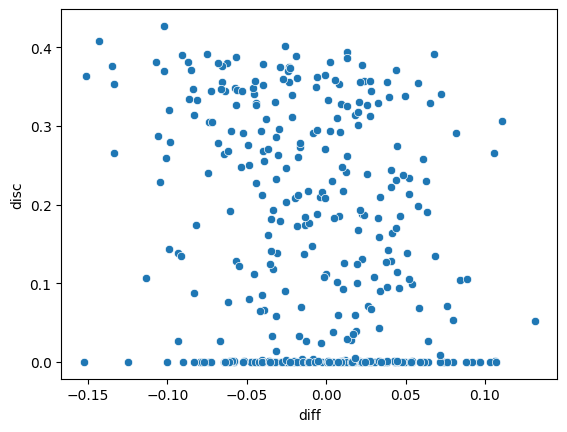

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

def format_irt(results):
    """
    output {"subject_id": "pedro", "q1": 1, "q2": 0, "q3": 1, "q4": 0}
    """
    records = []
    for name, g in results[['example_id', 'model', 'pass1']].groupby('model'):
        records.append(
            {'subject_id': name, **{r.example_id: r.pass1 for r in g.itertuples()}}
        )
    return records

def irt_ability(results):
    from py_irt.config import IrtConfig
    from py_irt.training import IrtModelTrainer
    from py_irt.dataset import Dataset
    from py_irt.models import OneParamLog
    df_irt = pd.DataFrame(format_irt(results))
    dataset = Dataset.from_pandas(df_irt, subject_column='subject_id')
    config = IrtConfig(model_type='2pl', log_every=200, dropout=0.2)
    trainer = IrtModelTrainer(config=config, data_path=None, dataset=dataset)
    trainer.train(epochs=5000, device='cpu')
    # trainer = OneParamLog.train(dataset)

    subjs = trainer.last_params['subject_ids']
    # print(trainer.last_params.keys())
    # dict_keys(['ability', 'diff', 'irt_model', 'item_ids', 'subject_ids'])
    items = trainer.last_params['item_ids']

    df_models = pd.DataFrame({'model': [subjs[k] for k in subjs], 'ability': trainer.last_params['ability']})
    df_items = pd.DataFrame({'example_id': [items[k] for k in items], 'diff': trainer.last_params['diff'], 'disc': trainer.last_params['disc']})
    return df_models, df_items

def get_ratings(results):
    battles = pass1_to_battle(results)
    battles_no_ties = battles[battles["winner"].str.contains("model_")]
    all_stats = result_table(battles_no_ties, results)
    ability, _ = irt_ability(results)
    all_stats = all_stats.merge(ability, on='model')
    return all_stats

def subsample(results, n=100):
    eids = set(results['example_id'])
    include_ids = np.random.choice(list(eids), n, replace=False)
    return results[results['example_id'].isin(include_ids)]


def compare_subsamples(benchmark_id):
    result = eval_results[eval_results['benchmark_id'] == benchmark_id]
    result1 = subsample(result)
    result2 = subsample(result)
    stats1 = get_ratings(result1)
    stats2 = get_ratings(result2)
    both_stats = stats1.merge(stats2, on='model')
    display(both_stats)
    # fig = px.scatter(both_stats, 'pass1_x', 'pass1_y')
    # fig = px.scatter(both_stats, 'pass1_x', 'pass1_y')
    # display(fig)
    return both_stats


# result = eval_results[eval_results['benchmark_id'] == 'mbpp+']
# result['pass1'] = np.where(result['pass1'] > 0.1, 1, 0)
# abilities, items = irt_ability(result)
# display(items)

sns.scatterplot(items, x='diff', y='disc')

# display(all_stats)

,model,pass1_x,win_rate_x,elo_x,ability_x,pass1_y,win_rate_y,elo_y,ability_y
0,claude-3-opus-20240229,0.73,0.831251,1301.684852,3.105959,0.77,0.855681,1334.569822,3.650471
1,gpt-4-1106-preview,0.72,0.816996,1291.569918,3.036648,0.77,0.816865,1281.262428,3.261962
2,meta-llama-3-70b-instruct,0.68,0.812167,1285.644990,3.317892,0.74,0.804370,1267.886061,3.451266
3,opencodeinterpreter-ds-33b,0.66,0.782301,1257.301221,3.453650,0.71,0.739754,1202.620149,3.469249
4,code-millenials-34b,0.67,0.779031,1251.023291,3.330586,0.66,0.633871,1107.374637,3.381397
5,claude-3-haiku-20240307,0.67,0.773281,1243.128600,3.028289,0.67,0.639642,1110.471407,2.807250
6,deepseek-coder-33b-instruct,0.66,0.749131,1217.027703,3.122629,0.71,0.709800,1171.322306,3.375802
7,HuggingFaceH4--starchat2-15b-v0.1,0.64,0.749126,1226.012409,3.161762,0.66,0.629905,1106.310395,3.571886
8,mixtral-8x22b-instruct-v0.1,0.64,0.740157,1213.349048,3.440726,0.65,0.612875,1089.237015,3.373090
9,starcoder2-15b-oci,0.63,0.717496,1187.654627,3.485852,0.67,0.639198,1108.963572,3.133225


<Axes: xlabel='ability_x', ylabel='ability_y'>

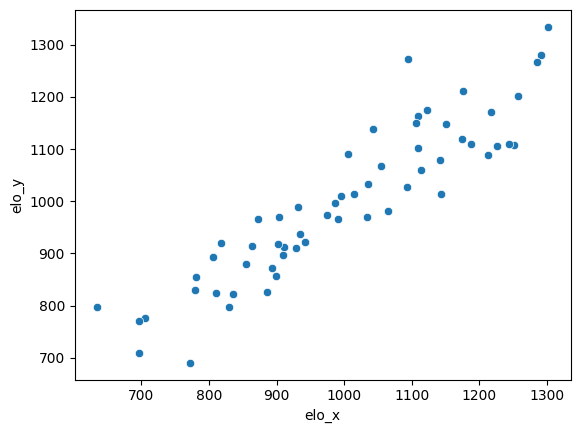

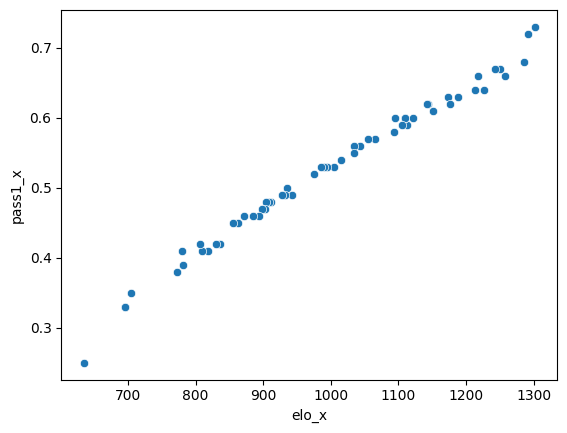

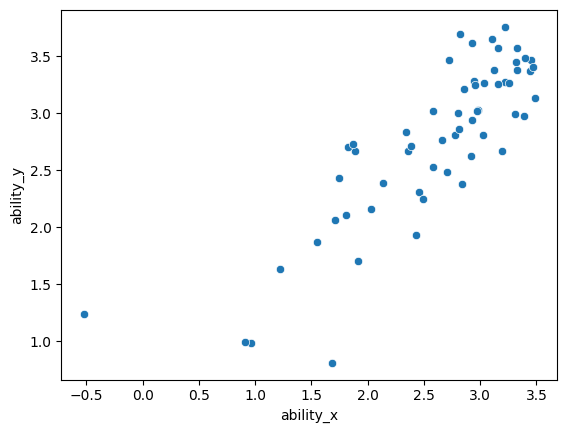

In [10]:
# both_stats = compare_subsamples('mbpp+')
display(both_stats)
plt.figure()
sns.scatterplot(both_stats, x='elo_x', y='elo_y')
plt.figure()
sns.scatterplot(both_stats, x='elo_x', y='pass1_x')
plt.figure()
sns.scatterplot(both_stats, x='ability_x', y='ability_y')


In [ ]:
sns.scatterplot(items, y='disc', x='diff')
df_irt = pd.DataFrame(format_irt(result))
battles = pass1_to_battle(result)
battles_no_ties = battles[battles["winner"].str.contains("model_")]
all_stats = result_table(battles_no_ties, result)
# example_table = gen_example_table(result, all_stats)
display(all_stats)
display(abilities)
ids = list(set(result['example_id']))
for id in ids[100:120]:
    plt.figure()
    result_id = result[result['example_id'] == id]
    pred_v_ability = result_id.merge(all_stats[['model', 'elo']], on = 'model')
    pred_v_ability = pred_v_ability.merge(abilities[['model', 'ability']], on = 'model')
    # display(pred_v_ability)
    plt.subplot(1,2,1)
    sns.scatterplot(pred_v_ability, x='elo', y='pass1')
    plt.subplot(1,2,2)
    sns.scatterplot(pred_v_ability, x='ability', y='pass1')
    item_info = items[items['example_id'] == id]
    plt.title(item_info)

,winner
example_id,
Mbpp/100,0.410871
Mbpp/101,0.237288
Mbpp/102,0.932788
Mbpp/103,1.000000
Mbpp/104,0.008767
...,...
Mbpp/95,0.005845
Mbpp/96,0.012274
Mbpp/97,0.016365


,benchmark_id_a,model_a,example_id,pass1_a,benchmark_id_b,model_b,pass1_b,winner
1,mbpp+,CohereForAI--c4ai-command-r-plus,Mbpp/100,1.0,mbpp+,HuggingFaceH4--starchat2-15b-v0.1,1.0,both
2,mbpp+,CohereForAI--c4ai-command-r-plus,Mbpp/100,1.0,mbpp+,Qwen--Qwen1.5-72B-Chat,0.0,model_a
3,mbpp+,CohereForAI--c4ai-command-r-plus,Mbpp/100,1.0,mbpp+,bigcode--starcoder2-15b-instruct-v0.1,0.0,model_a
4,mbpp+,CohereForAI--c4ai-command-r-plus,Mbpp/100,1.0,mbpp+,claude-3-haiku-20240307,0.0,model_a
5,mbpp+,CohereForAI--c4ai-command-r-plus,Mbpp/100,1.0,mbpp+,claude-3-opus-20240229,1.0,both


,example_id,winner,pass1_a,pass1_b
0,Mbpp/100,0.410871,1.0,1.0
1,Mbpp/101,0.237288,0.0,1.0
2,Mbpp/102,0.932788,0.0,0.0
3,Mbpp/103,1.000000,0.0,0.0
4,Mbpp/104,0.008767,1.0,1.0
...,...,...,...,...
373,Mbpp/95,0.005845,1.0,1.0
374,Mbpp/96,0.012274,1.0,1.0
375,Mbpp/97,0.016365,1.0,1.0
376,Mbpp/98,0.053185,1.0,1.0


k / n = 16/62	 thres: 0.042328042328042326
pvalue 0.05752999999999997
uniform 0.05752999999999996
k / n = 16/62	 thres: 0.0010222928765713443
pvalue 0.95494
win_prob 0.95494
k / n = 16/62	 thres: 0.05656108597285067
pvalue 0.022760000000000002
if2 0.022760000000000016
k / n = 16/62	 thres: 0.038665072593133835
pvalue 0.06508000000000003
disc 0.06508000000000003
k / n = 16/62	 thres: 0.051441955850528784
pvalue 0.032159999999999966
rand 0.03216000000000001


/private/home/sida/.conda/envs/codegen_240116_sida/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)


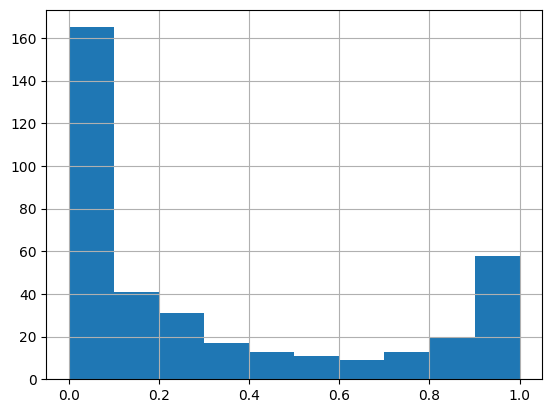

<Figure size 640x480 with 0 Axes>

/private/home/sida/.conda/envs/codegen_240116_sida/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


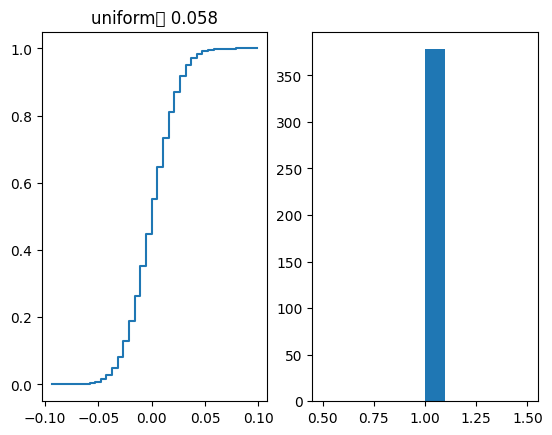

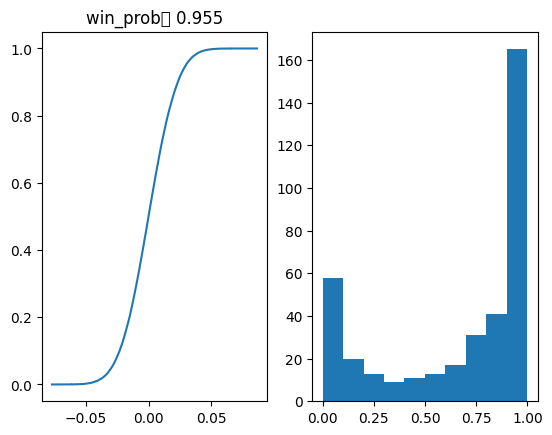

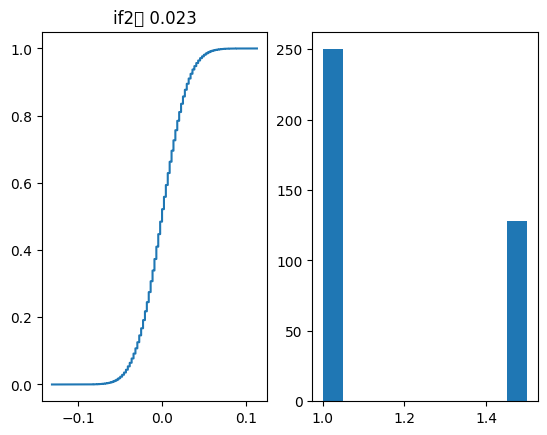

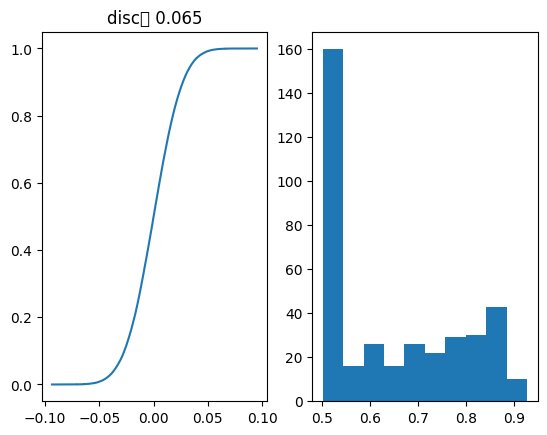

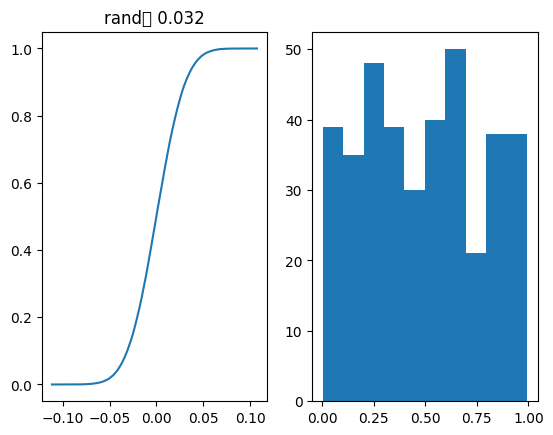

In [22]:
import report_agg
from report_agg import result_table, pass1_to_battle
import numpy.random as rng
import arena
import matplotlib.pyplot as plt
import importlib
importlib.reload(arena)

result = eval_results[eval_results['benchmark_id'] == 'mbpp+']
battles = pass1_to_battle(result)

def estimate_tie_probs(battles: pd.DataFrame):
    pass

estimate_tie_probs(battles)
win_probs = battles.groupby(by='example_id')[['winner']].aggregate(lambda x: 2*np.mean(x == 'model_a'))
tie_probs = battles.groupby(by='example_id')[['winner']].aggregate(lambda x: np.mean((x == 'neither') | (x == 'both')))
tie_probs = battles.groupby(by='example_id')[['winner']].aggregate(lambda x: np.mean((x == 'neither')))
# display(tie_probs.describe())
# tie_probs.hist()
display(tie_probs)

m = list(set(battles['model_a']))
display(battles.head())
# ma = 'claude-3-opus-20240229'
# mb = 'opencodeinterpreter-ds-33b'
# mb = 'meta-llama-3-70b-instruct'
# ma = 'deepseek-coder-33b-instruct'
# mb = 'deepseek-coder-6.7b-instruct'
ma = 'codellama-34b'
mb = 'codellama-13b'
# mb = 'codellama-7b'
ma = 'gpt-4-1106-preview'
mb = 'meta-llama-3-70b-instruct'
result_a = result[result['model'] == ma][['example_id', 'pass1']]
result_b = result[result['model'] == mb][['example_id', 'pass1']]
result_ab = result_a.merge(result_b, on='example_id', suffixes=['_a', '_b'])
res_withprob = pd.merge(tie_probs, result_ab, on='example_id')
display(res_withprob)
res_withprob['winner'].hist()
tie_probs = res_withprob['winner'].to_numpy()
win_prob = (1 - tie_probs) 
weights = 1 - win_prob 
weights = {
    'uniform': np.ones(win_prob.shape), 
    'win_prob': win_prob,
    'if2': np.where((0.05 < win_prob) & (win_prob < 0.8), 1.5, 1),
    'disc': 0.5 + result_ab[['example_id']].merge(items, on='example_id')['disc'].to_numpy(),
    'rand': np.random.rand(*win_prob.shape),
}

plt.figure()
for w in weights:
    we = weights[w]
    assert all(we >= 0)
    # cdf, pv = arena.sign_test_niid(res_withprob['pass1_a'].to_numpy(), res_withprob['pass1_b'].to_numpy(), res_withprob['winner'].to_numpy(), we) 
    cdf, pv = arena.sign_test_niid(res_withprob['pass1_a'].to_numpy(), res_withprob['pass1_b'].to_numpy(), None, we, sample_all=False) 
    plt.figure()
    ax = plt.subplot(1, 2, 1)
    cdf.plot(ax)
    plt.title(f'{w}\t {pv:.3f}')
    ax = plt.subplot(1, 2, 2)
    ax.hist(we)
    print(w, pv)

In [ ]:
display(items)

In [ ]:
importlib.reload(arena)

res_a = res_withprob['pass1_a'].to_numpy()
res_b = res_withprob['pass1_b'].to_numpy()
tie_probs = np.mean(res_a == res_b) * np.ones(res_b.size)
# print(tie_probs)
weights = 1*np.ones(res_b.size)
cdf, pv = arena.sign_test_niid(res_a, res_b, tie_probs, weights, sample_all=True) 

print(pv)

import scipy.stats as stats
k = np.sum(res_a > res_b)
n = np.sum(res_a != res_b)
print(k, n)
print('binom', stats.binomtest(k, n, p=0.5, alternative='two-sided').pvalue)

ax = plt.subplot()
cdf.plot(ax)

cdf.evaluate(-0.01)